In [1]:
%run -i ./preamble.py
%config InlineBackend.figure_format = 'retina'
%load_ext nb_black

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import sys, pandas

print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)
print("Pandas version:", pandas.__version__)

tic()

Python version: 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:45:16) 
[GCC 9.3.0]
Numpy version: 1.20.2
PyMC3 version: 3.11.2
Arviz version: 0.11.2
Pandas version: 1.2.3


In [3]:
FAST = False

# Processor information and SMC calibration parameters
if not FAST:
    numIters = 15
    popSize = 1000
    epsMin = 0
else:
    numIters = 5
    popSize = 100
    epsMin = 1

smcArgs = {"epsMin": epsMin, "verbose": True}
smcArgs["numProcs"] = 64

In [4]:
rg = default_rng(123)

sample_sizes = [50, 250]
T = sample_sizes[-1]

# Frequency-Loss Model
sigma = 0.2
w1 = 15
w2 = 5
m1 = 10
m2 = 40
θ_True = sigma, w1, w2, m1, m2

freq = "bivariate poisson"
sev = "exponential"

# Aggregation process
psi = abcre.Psi("sum")

claimsData = abcre.simulate_claim_data(rg, T, freq, sev, θ_True)

xData1 = abcre.compute_psi(claimsData[0][0], claimsData[0][1], psi)
xData2 = abcre.compute_psi(claimsData[1][0], claimsData[1][1], psi)

xData = (xData1, xData2)

In [5]:
prior = abcre.IndependentUniformPrior([(0, 2), (0, 50), (0, 50), (0, 100), (0, 100)])
model = abcre.Model("bivariate poisson", "exponential", psi, prior)

In [6]:
params = ("sigma", "w1", "w2", "m1", "m2")
dfABCOld = pd.DataFrame()

for ss in sample_sizes:
    xDataSS = np.vstack([xData1[:ss], xData2[:ss]]).T

    %time fit =  abcre.smc(numIters, popSize, xDataSS, model, sumstats=abcre.wass_2Ddist_ss, distance=abcre.wass_2Ddist, **smcArgs)

    columns = {"ss": np.repeat(ss, popSize), "weights": fit.weights}
    for i, param in enumerate(params):
        columns[param] = fit.samples[:, i]

    res = pd.DataFrame(columns)

    dfABCOld = pd.concat([dfABCOld, res])

Final population dists <= 59.59, ESS = 763
CPU times: user 26 s, sys: 1.63 s, total: 27.6 s
Wall time: 1min 38s


Final population dists <= 45.40, ESS = 684
CPU times: user 20.9 s, sys: 998 ms, total: 21.9 s
Wall time: 2min 51s


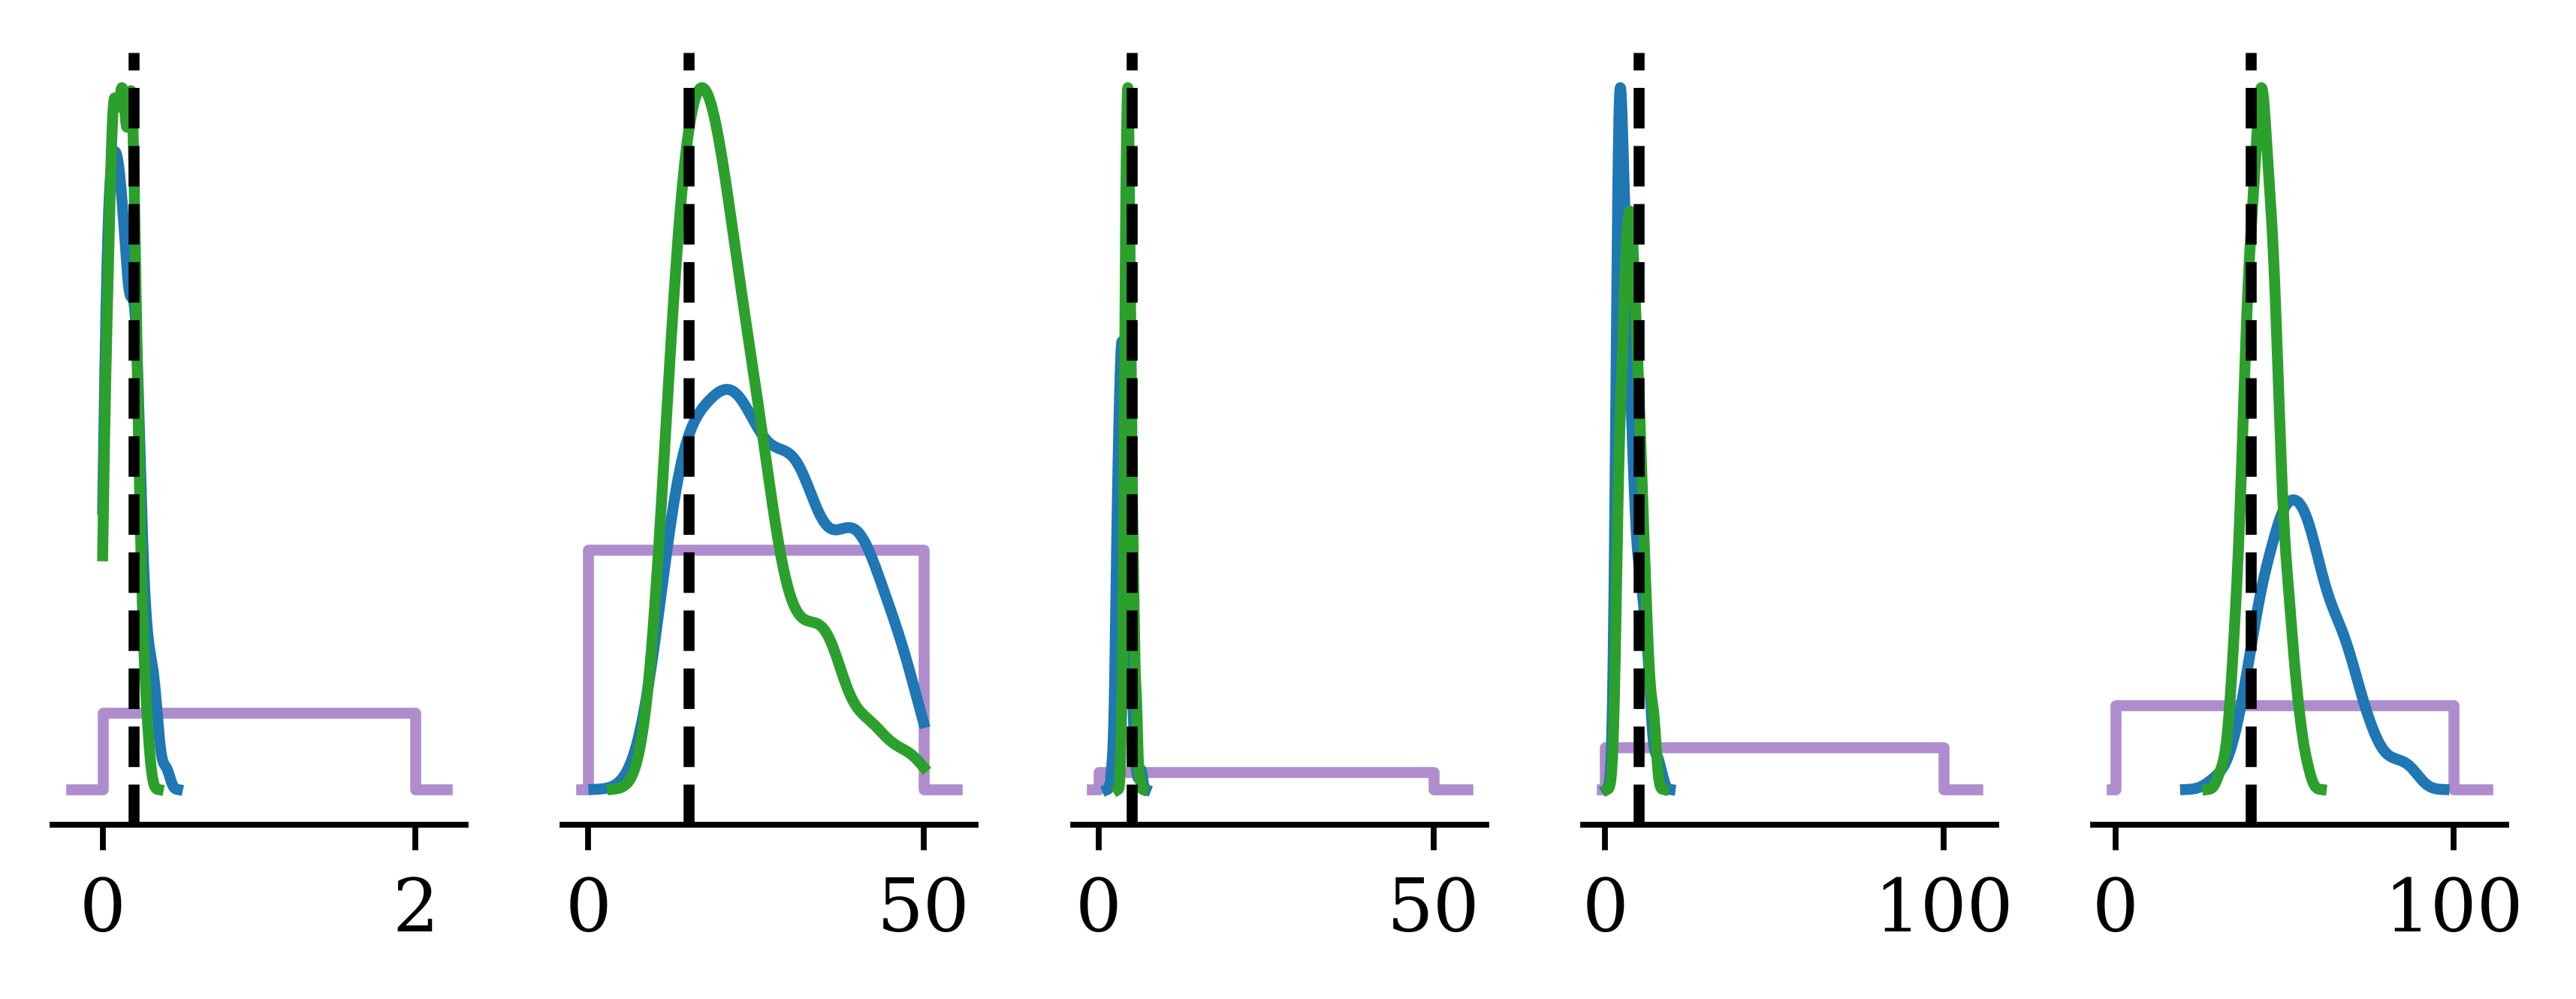

In [7]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABCOld.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")

    axs[l].axvline(θ_True[l], **trueStyle)
    #     axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-bivariate-poisson-exp.pdf")


In [8]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 274 secs = 4.57 mins


In [9]:
dill.dump_session("Sim_Bivariate_Poisson_Exp.pkl")